In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, draw, show, ion
import matplotlib.image as mpimg
import cv2
import scipy.io
from tqdm import tqdm

# from scipy.stats import ortho_group
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
from WSMBSS import *
from numba import njit
import warnings
warnings.filterwarnings("ignore")
np.random.seed(250)

In [2]:
def Subplot_RGB_images(I, imsize = [3240, 4320], height = 15, width = 15, title = ''):
    n_images = I.shape[0]
    Im = [I[i,:].reshape(imsize[0],imsize[1],3) for i in range(I.shape[0])]
    fig, ax = plt.subplots(1,n_images, figsize = (25,50))
    fig.suptitle(title)
    fig.set_figheight(height)
    fig.set_figwidth(width)   
    for i in range(n_images):
        ax[i].imshow(Im[i])
        ax[i].axes.xaxis.set_visible(False)
        ax[i].axes.yaxis.set_visible(False)
    plt.subplots_adjust(right=0.97,\
                    left=0.03,\
                    bottom=0.03,\
                    top=0.97,\
                    wspace=0.1,\
                    hspace=0.1)
    plt.draw()    

In [3]:
os.chdir("..")
os.chdir("./NumericalExperiments/ImageSeparation")
image_paths = 'TestImages'
images = []
for im_dir in os.listdir(image_paths):
    try:
        images.append(mpimg.imread(os.path.join(image_paths,im_dir)))
    except:
        pass
images = np.array(images)

In [4]:
small_images = np.zeros((images.shape[0],324* 432* 3))
small_to_large_image_size_ratio = 0.1
for i in range(images.shape[0]):
    small_img = cv2.resize(images[i], # original image
                           (0,0), # set fx and fy, not the final size
                           fx=small_to_large_image_size_ratio, 
                           fy=small_to_large_image_size_ratio, 
                           interpolation=cv2.INTER_NEAREST)
    if small_img.shape[0] == 302:
        small_img = cv2.resize(small_img, (0,0), fx = 432/403, fy = 324/302)
    print(small_img.shape)
    small_images[i] = small_img.reshape(-1,)/255

small_images.shape

(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)


(4, 419904)

<IPython.core.display.Math object>

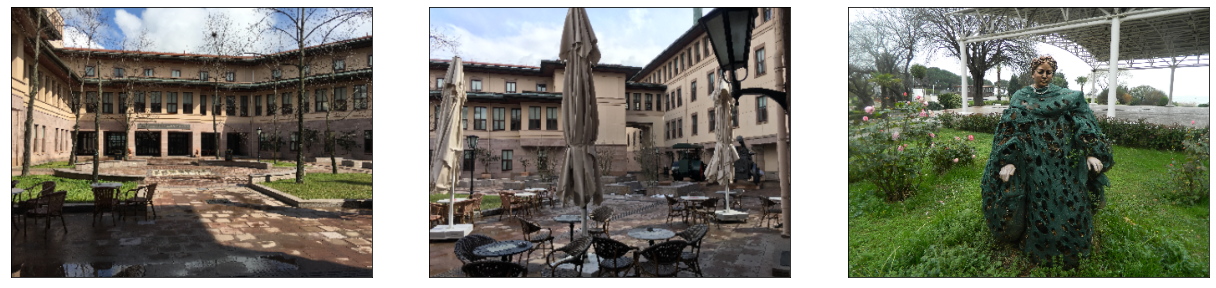

In [5]:
S = small_images[[0,2,3]]
Subplot_RGB_images(S, imsize = [324,432], height = 4, width = 18)
display_matrix(np.corrcoef(S))
plt.savefig('Original_Images.pdf', format = 'pdf', dpi = 1500)

In [6]:
np.random.seed(50)
NumberofMixtures = 5
NumberofSources = 3
# S_ = 2 * S - 1
INPUT_STD = 0.28
A = np.random.standard_normal(size=(NumberofMixtures,NumberofSources))
# A = np.random.uniform(size=(NumberofMixtures,NumberofSources))
X = A @ S
for M in range(A.shape[0]):
    stdx = np.std(X[M,:])
    A[M,:] = A[M,:]/stdx * INPUT_STD
    
SNR=40
# A = np.abs(A)
Xn = A @ S
Noisecomp=np.random.randn(A.shape[0],S.shape[1])*np.power(10,-SNR/20)*INPUT_STD
X=Xn+Noisecomp

print(20*np.log10(np.std(Xn)/np.std(Noisecomp)))

X_ = ZeroOneNormalizeColumns(X.T).T
print('The following is the mixture matrix')
display_matrix(A)

41.122659361820595
The following is the mixture matrix


<IPython.core.display.Math object>

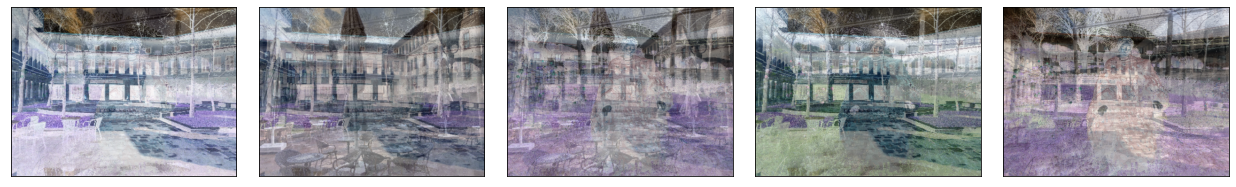

In [7]:
Subplot_RGB_images(X_, imsize = [324,432], height = 3, width = 18)
# plt.savefig('Mixture_Images.pdf', format = 'pdf', dpi = 1500)

In [8]:
MUS = 0.11
OUTPUT_COMP_TOL = 1e-7
MAX_OUT_ITERATIONS= 3000
LayerGains = [1,1]
LayerMinimumGains = [1e-3,1e-3]
LayerMaximumGains = [1e6,20]
WScalings = [0.0033,0.0033]
GamScalings = [2,1]
zeta = 1*1e-5
beta = 0.5
muD = [3.725, 1.125]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
W_HX = np.eye(h_dim, x_dim)
W_YH = np.eye(s_dim, h_dim)
W_HX = W_HX + (W_HX!=0)*np.random.uniform(-0.01,0.01, size = (W_HX.shape[0], W_HX.shape[1]))
W_YH = W_YH + (W_YH!=0)*np.random.uniform(-0.01,0.01, size = (W_YH.shape[0], W_YH.shape[1]))
model = OnlineWSMBSS(s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                     gamma_start = MUS, gamma_stop = 1e-4, beta = beta, zeta = zeta, 
                     muD = muD,WScalings = WScalings, GamScalings = GamScalings,
                     W_HX = W_HX, W_YH = W_YH,
                     DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                     LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                     set_ground_truth = True, S = S, A = A)

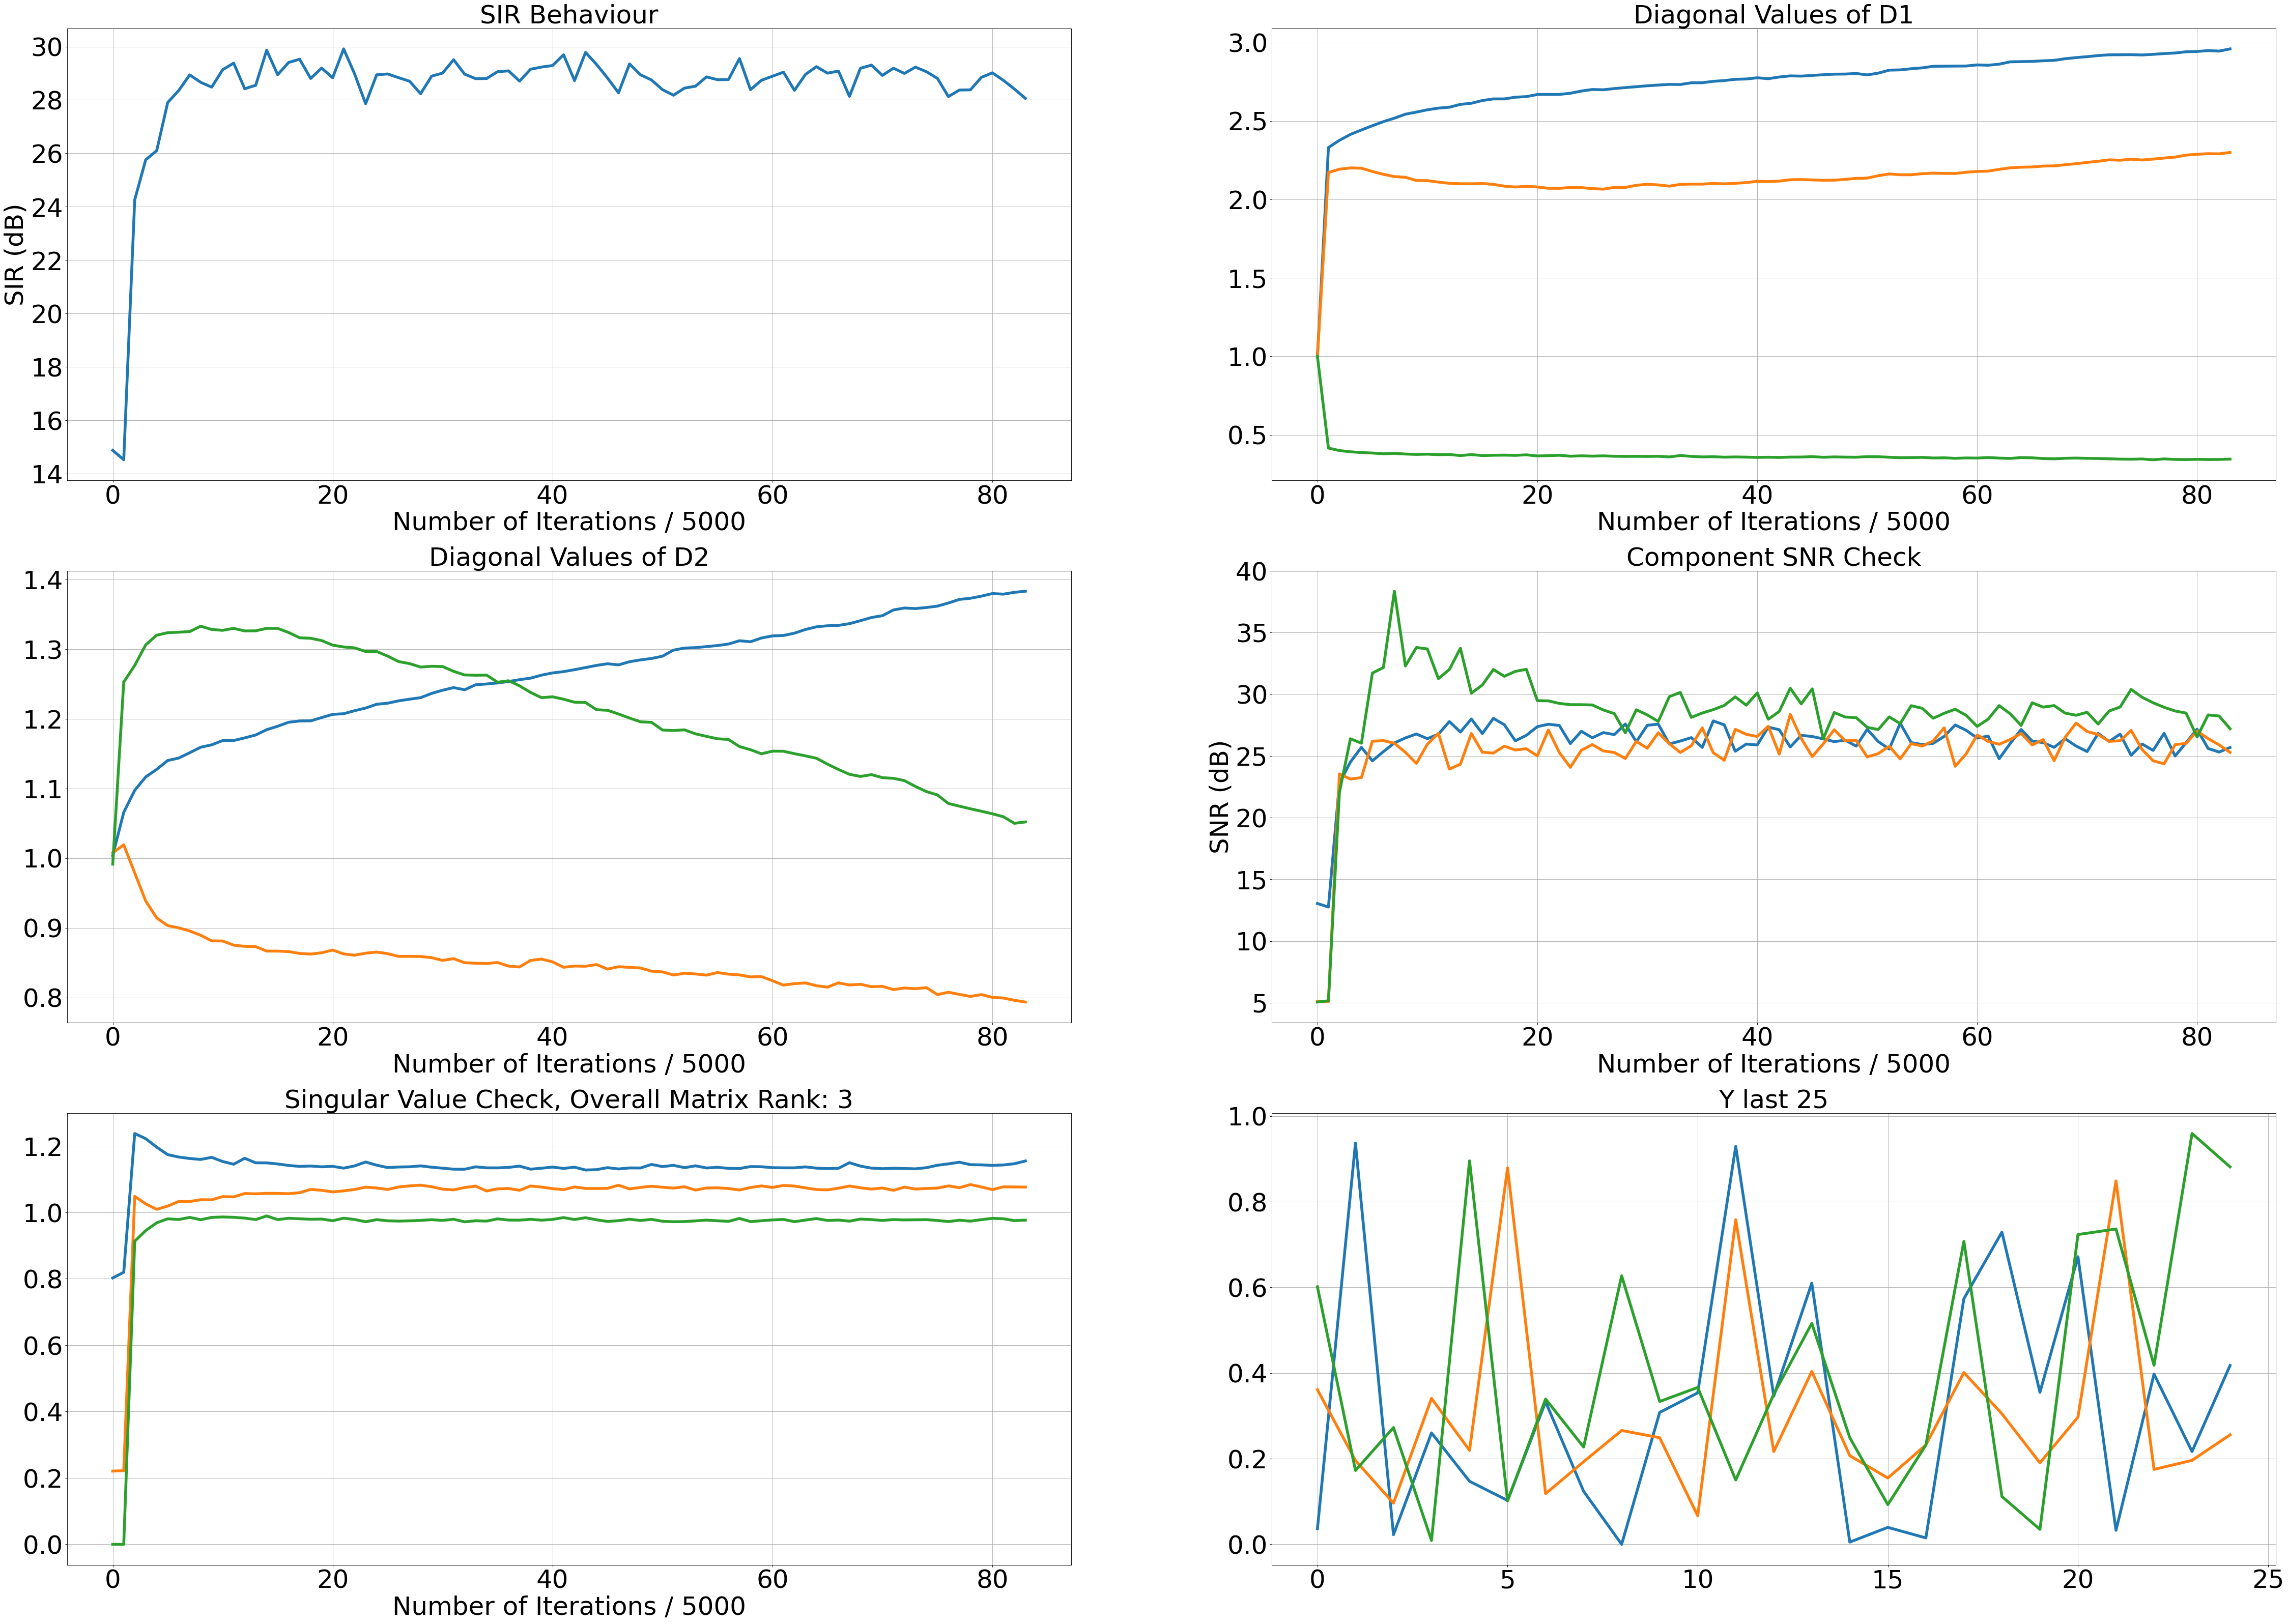

100%|██████████| 419904/419904 [49:42<00:00, 140.81it/s]


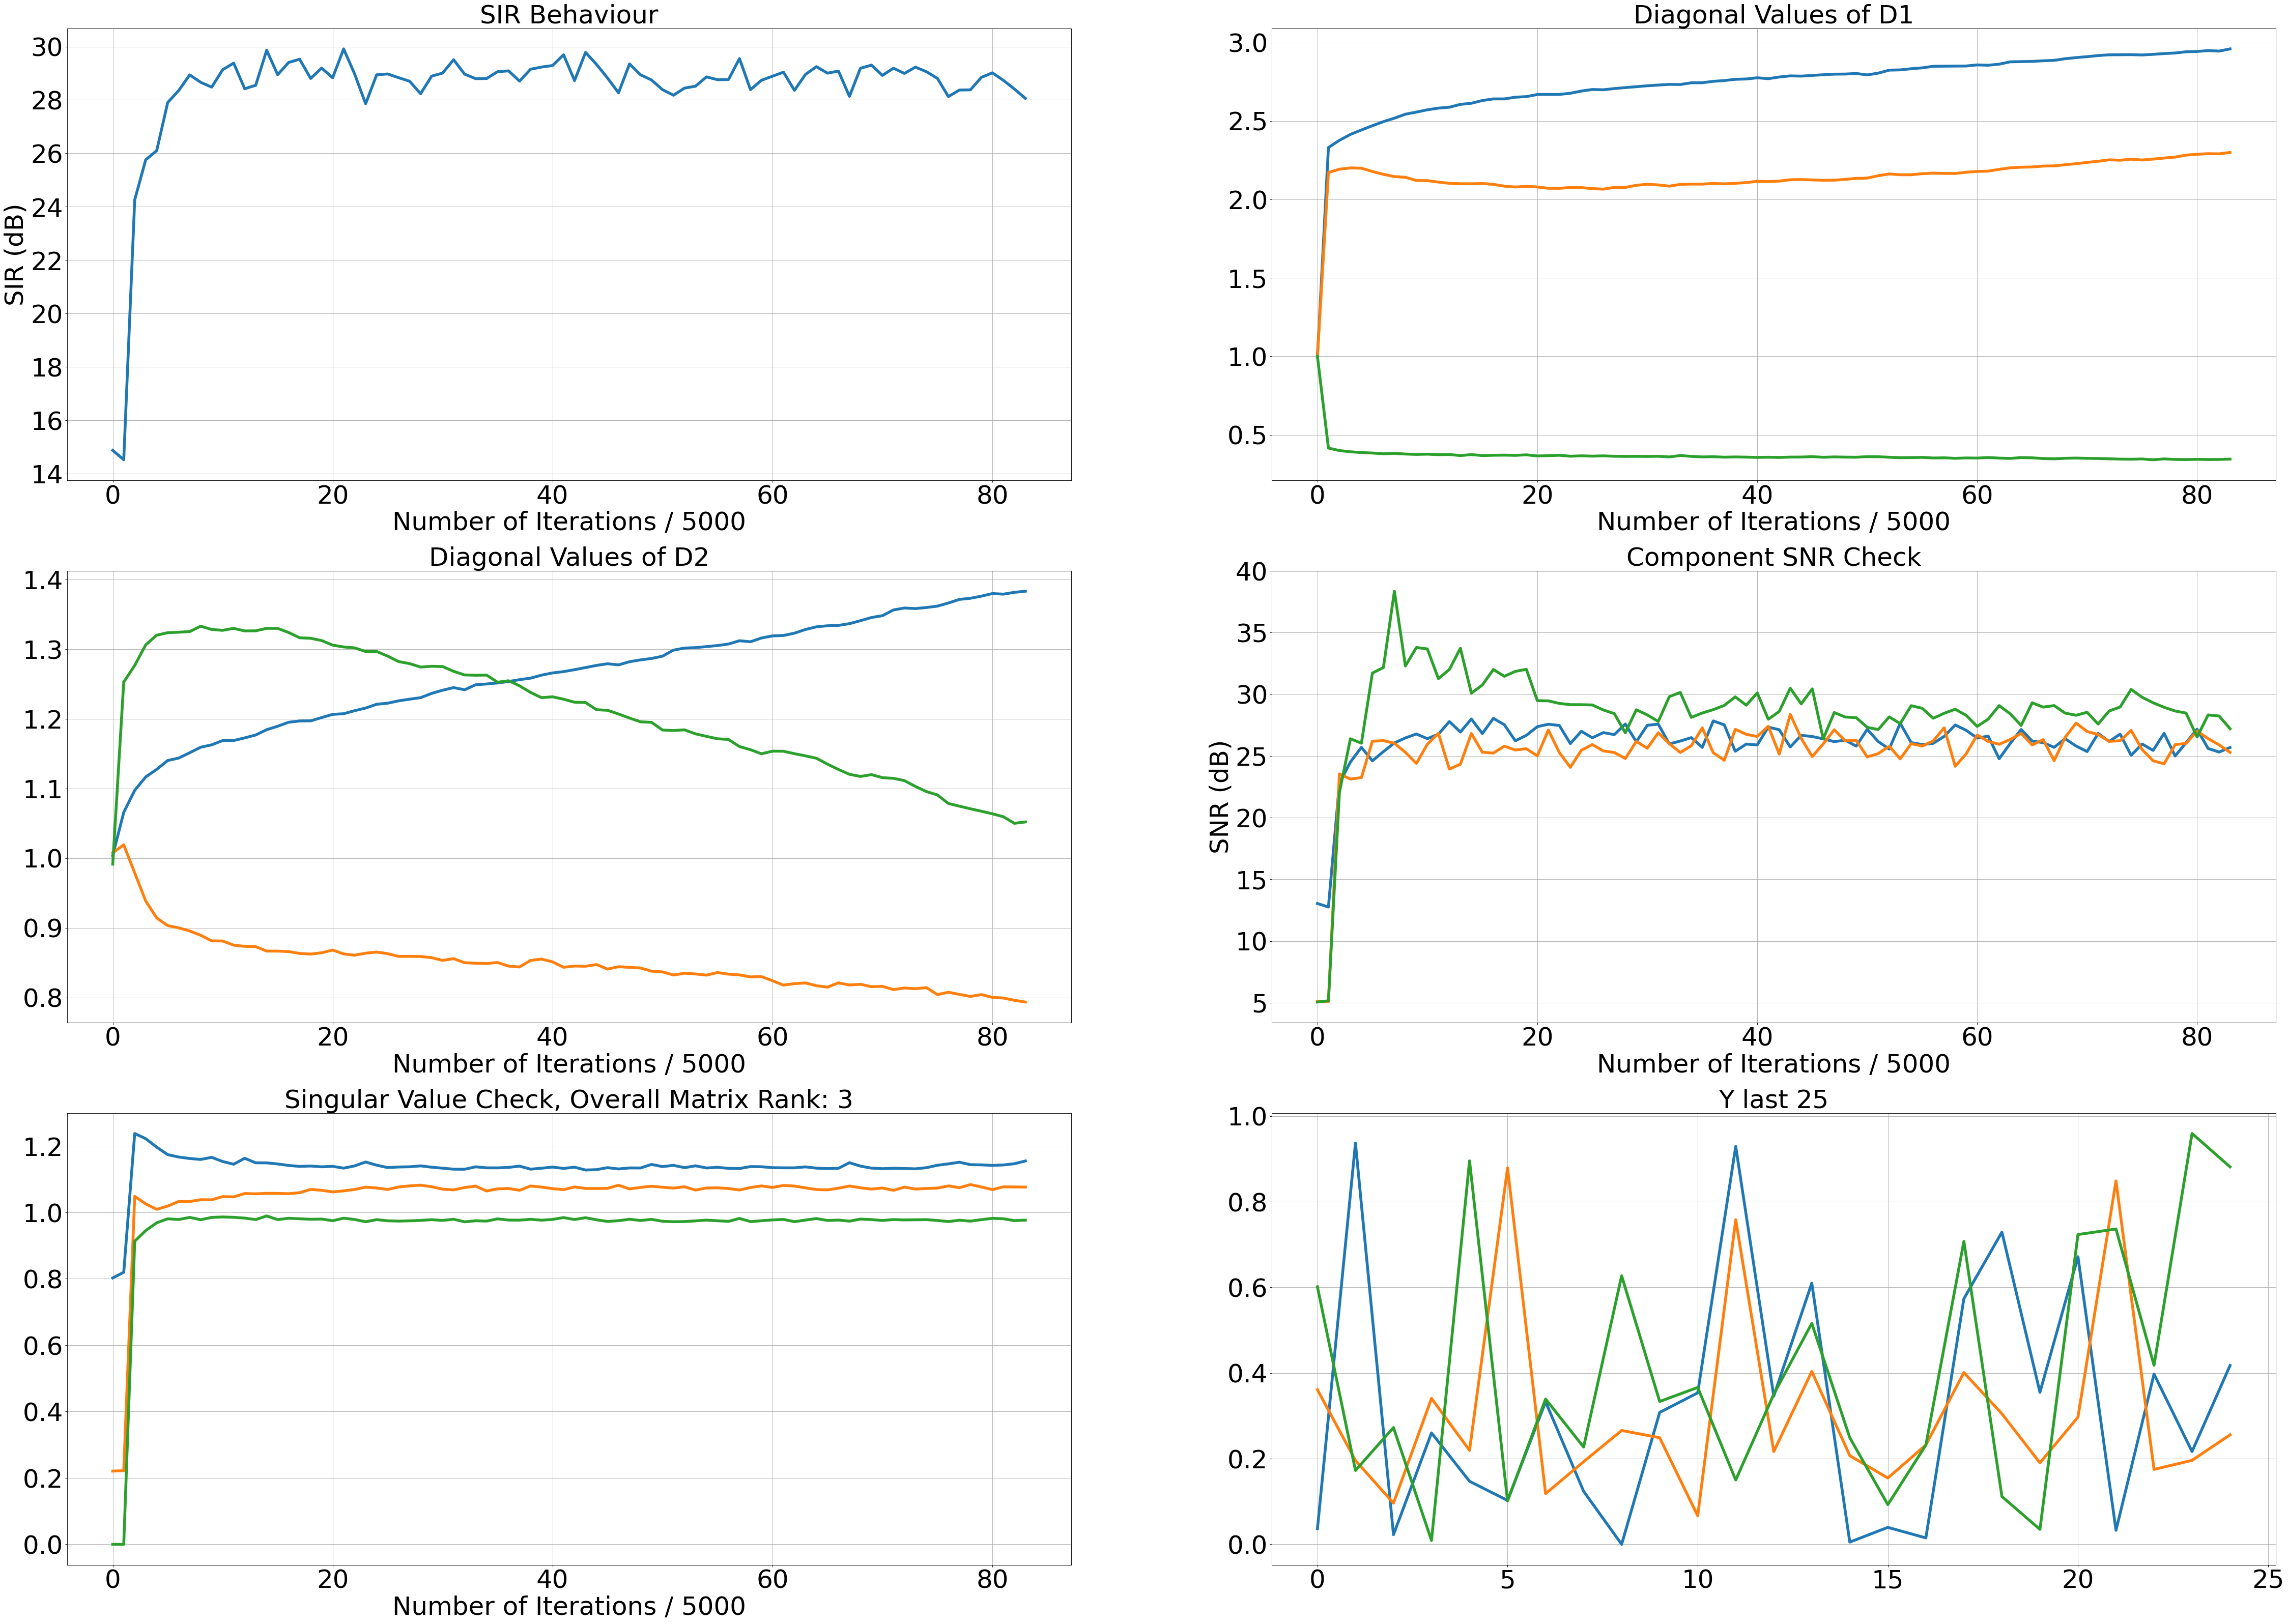

In [9]:
debug_iteration_point = 5000
model.fit_batch_nnantisparse(X, n_epochs = 1, 
                             neural_dynamic_iterations = 500,
                             neural_lr_start = 0.75,
                             neural_lr_stop = 0.05,
                             debug_iteration_point = debug_iteration_point,
                             plot_in_jupyter = True,
                            )

In [10]:
W = model.compute_overall_mapping(return_mapping = True)
Y_ = W @ X
10*np.log10(CalculateSINR(Y_, S)[0])

27.489769571377604

In [11]:
W = model.compute_overall_mapping(return_mapping = True)
Y_ = W @ X
Y_ = signed_and_permutation_corrected_sources(S.T,Y_.T)
coef_ = (Y_ * S.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_

In [12]:
# W = model.compute_overall_mapping(return_mapping = True)
# Y_ = W @ X
# Y_ = signed_and_permutation_corrected_sources(S.T,Y_.T)
# coef_ = (Y_ * S.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
# Y_ = coef_ * Y_
snr(S.T, Y_)

array([26.19773493, 24.66203334, 25.4650675 ])

In [13]:
10*np.log10(CalculateSINR(Y_.T, S)[0])

27.491604516551874

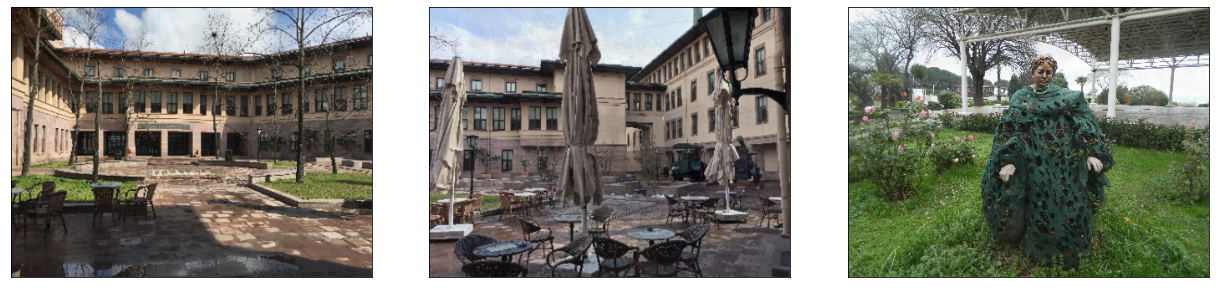

In [14]:
Subplot_RGB_images(ZeroOneNormalizeColumns(Y_).T, imsize = [324,432], height = 4, width = 18)
# plt.savefig('WSM_Output.pdf', format = 'pdf', dpi = 1500)

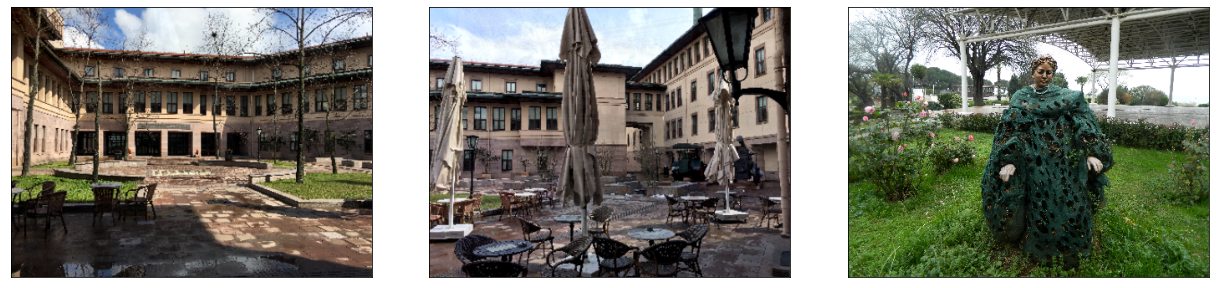

In [15]:
Subplot_RGB_images(np.clip(Y_.T, 0,1), imsize = [324,432], height = 4, width = 18)
# plt.savefig('WSM_Output_Clipped.pdf', format = 'pdf', dpi = 1500)